# Asset Pricing 2: Homework 1

### Trent Potter

### Winter 2025

---

### Outline

#### Data

- `StockPortfolios.csv`: monthly stock returns of 30 portfolios from 1963-10 to 2013-12
- `FFMktFct.csv`: monthly broad market returns and tbills returns of 30 portfolios from 1963-10 to 2016-07

#### Problem 1: Estimating an SDF with the Market Factor

**Estimation Procedures**

Calculate SDF parameters ($b$ and $µ_F$), standard errors, $\chi^2$-statistics, and HJ-distance under three difference cases:

- **Assumption IID**: Equivalent to timeseries regression.
- **First-stage GMM**: Using $W=I$ weight matrix.
- **Two-step GMM**: Using optimal $W=S^{-1}$ weight matrix.  
  Discussion follows.

#### Problem 2: Principal Component Factors in the SDF

**Estimation Procedures**

Compute the first five principal components of the 30 portfolio excess returns, then re-run the above analysis.

- **Assumption IID**: Equivalent to timeseries regression.
- **First-stage GMM**: Using $W=I$ weight matrix.
- **Two-step GMM**: Attempt optimal $W=S^{-1}$ weight matrix.
  - Investigating invertibility of $S$ matrix
  - Using pseudo-inverse of $S$
  - Without $K$ pricing factor moment conditions

**Analysis and Discussion**

- Proof / Disproof on equivalence time-series regression and GMM on PCs as factors.
- Explaining results from alternative approaches (pseudo-inverse and reduced moment conditions)
- Discussion of pseudo-inverse's impact on weighting


In [8]:
import pandas as pd
import numpy as np
from numpy.linalg import inv as inv
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from scipy.stats import chi2

display(
    HTML(
        '<script type="text/javascript" async src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/MathJax.js?config=TeX-MML-AM_SVG"></script>'
    )
)
pd.set_option("display.float_format", lambda x: "%.4f" % x)
np.set_printoptions(formatter={'float': '{:0.4g}'.format})


In [9]:
# Read in the CSV files
stock_portfolios = pd.read_csv(
    "StockPortfolios.csv", index_col=0, parse_dates=True, date_format="%Y%m"
)
ff_mkt_fct = pd.read_csv(
    "FFMktFct.csv", index_col=0, parse_dates=True, date_format="%Y%m"
)

# Truncate ff_mkt_fct to the same time period as stock_portfolios
ff_mkt_fct = ff_mkt_fct.loc[:"2013-12"]

# Concatenate the two dataframes along the column axis
Z = pd.concat([stock_portfolios / 100, ff_mkt_fct], axis=1)

# Subtract the "Tbill" column from every other column
for column in Z.columns:
    if column != "Tbill":
        Z[column] = Z[column] - Z["Tbill"]
Z.drop("Tbill", axis=1, inplace=True)

display(Z)

,Size_Short,Size_Long,GrossProfitability_Short,GrossProfitability_Long,Value_Short,Value_Long,ValProf_Short,ValProf_Long,Accruals_Short,Accruals_Long,...,ValMom_Long,IdiosyncraticVolatility_Short,IdiosyncraticVolatility_Long,Momentum_Short,Momentum_Long,LongRunReversals_Short,LongRunReversals_Long,BetaArbitrage_Short,BetaArbitrage_Long,Rmarket
1963-10-01,0.0325,0.0025,-0.0046,0.0099,0.0366,0.0024,-0.0127,0.0129,0.0001,0.1088,...,0.0092,0.0113,0.0376,0.0174,0.0497,0.0316,-0.0007,0.0199,-0.0066,0.0253
1963-11-01,-0.0082,-0.0238,-0.0059,-0.0175,-0.0015,0.0063,-0.0113,-0.0025,-0.0142,-0.0463,...,0.0151,-0.0265,0.0101,-0.0021,-0.0032,0.0107,0.0010,-0.0154,-0.0146,-0.0085
1963-12-01,0.0230,-0.0259,0.0198,0.0030,0.0246,0.0343,0.0219,-0.0161,0.0089,0.0148,...,0.0384,-0.0063,0.0202,-0.0272,0.0040,0.0117,-0.0087,0.0020,0.0139,0.0183
1964-01-01,0.0282,0.0409,0.0157,0.0085,0.0261,0.0259,0.0138,0.0248,0.0362,0.0324,...,0.0362,-0.0179,0.0342,0.0146,0.0140,0.0181,0.0426,0.0170,0.0109,0.0224
1964-02-01,0.0121,0.0246,0.0093,0.0154,0.0193,0.0587,0.0089,0.0428,0.0144,0.0221,...,0.0458,0.0140,0.0092,0.0176,0.0321,0.0159,0.0258,0.0138,0.0113,0.0154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-08-01,-0.0282,-0.0284,-0.0292,-0.0279,-0.0204,-0.0367,-0.0178,-0.0277,-0.0173,-0.0047,...,-0.0469,0.0067,-0.0443,0.0301,-0.0270,-0.0095,-0.0415,-0.0211,-0.0420,-0.0271
2013-09-01,0.0296,0.0640,0.0274,0.0584,0.0626,0.0239,0.0673,0.0793,0.0649,0.0716,...,0.0254,0.0832,0.0200,0.0052,0.0740,0.0437,0.0266,0.0784,0.0160,0.0377
2013-10-01,0.0475,0.0194,0.0152,0.0398,0.0380,0.0323,0.0272,0.0567,0.0154,0.0414,...,0.0349,-0.0109,0.0466,0.0512,0.0236,0.0462,0.0300,0.0173,0.0465,0.0418
2013-11-01,0.0338,0.0544,-0.0069,0.0218,0.0261,0.0534,0.0269,0.0198,0.0311,0.0234,...,0.0505,0.0282,0.0347,0.0321,0.0335,0.0413,0.0730,0.0441,0.0303,0.0312


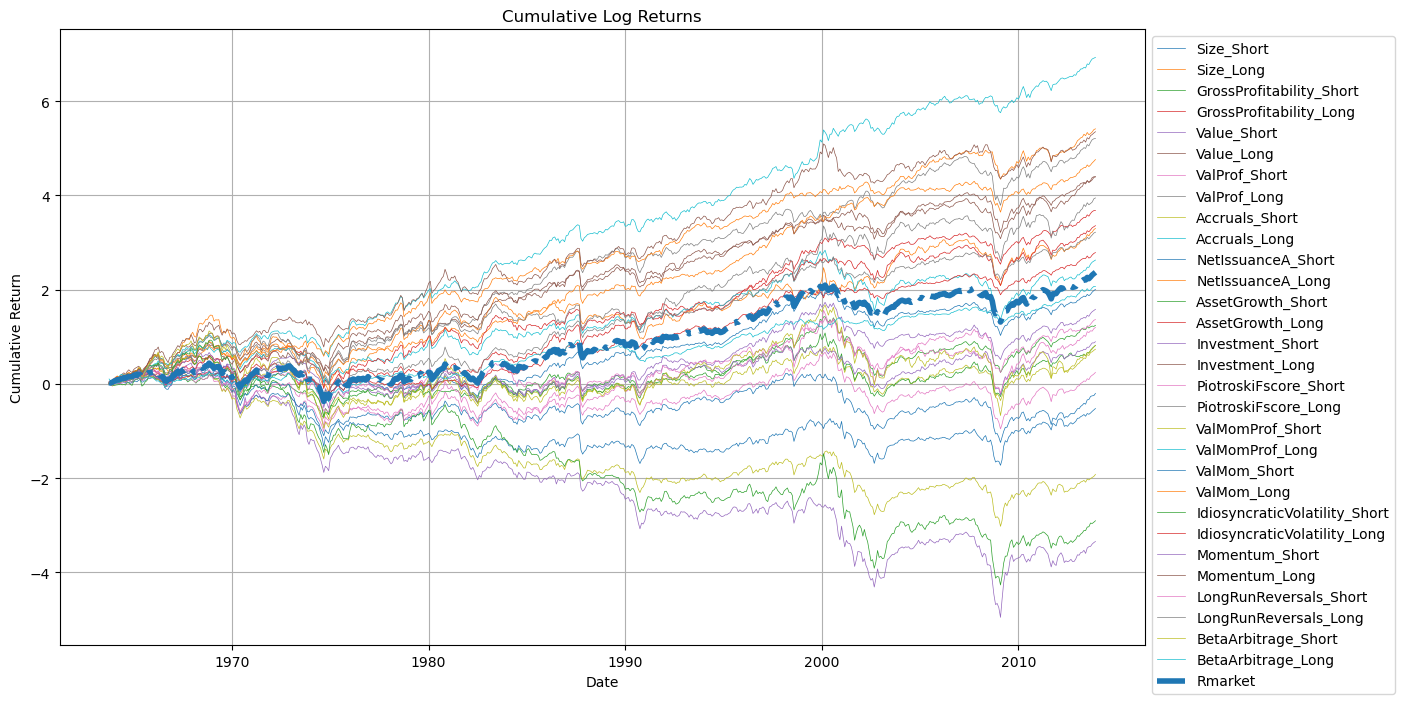

In [10]:
# Calculate cumulative returns
cumulative_log_returns = np.log((1 + Z).cumprod())

# Plot cumulative returns
plt.figure(figsize=(14, 8))
for column in cumulative_log_returns.columns:
    if column == "Rmarket":
        plt.plot(
            cumulative_log_returns.index,
            cumulative_log_returns[column],
            label=column,
            linewidth=4,
            linestyle="-.",
        )
    else:
        plt.plot(
            cumulative_log_returns.index,
            cumulative_log_returns[column],
            label=column,
            linewidth=0.5,
        )

# Add legend
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.title("Cumulative Log Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

# Problem 1 - SDF Estimation w/ Market Factor


In [11]:
# Market Factor
F = Z["Rmarket"]
F = F.to_numpy().reshape(-1, 1)
Z = Z.iloc[:, :-1].reset_index(drop=True)

T = Z.shape[0]
N = Z.shape[1]
K = F.shape[1]

In [12]:
# Approach 1, with matrix OLS interpretation
beta = inv(F.T @ F) @ F.T @ Z
alpha = (Z.reset_index(drop=True) - (beta.T @ F.T).T).mean()
factor_cov = F.T @ F / T
mu_hat = F.mean().reshape(1, 1)
b_hat = inv(factor_cov) @ mu_hat
theta_hat_iid = np.array([b_hat.item(), mu_hat.item()])

# Errors
epsilon = Z - (beta.T @ F.T).T
epsilon_cov = epsilon.T @ epsilon
square_sharpe = alpha.T @ inv(epsilon_cov) @ alpha


# JT test, Chi-squared with N-K -> 30 (Z) + 2 (factor px'ing & mean) - 2 (b & mu) = 30 DOF
T = Z.shape[0]
JT = (
    T
    * alpha.T
    @ inv(epsilon_cov)
    @ alpha
    * inv(1 + mu_hat.T @ inv(factor_cov) @ mu_hat).item()
)
p_value = 1 - chi2.cdf(JT, df=30)

iid_result = pd.concat(
    [
        pd.Series(beta.T[0], index=Z.columns, name="beta"),
        pd.Series(alpha, index=Z.columns, name="alpha"),
    ],
    axis=1,
)
print(
    f""" {'='*30} IID Results {'='*30}
    b_hat: {b_hat[0][0]:0.5g}\tmu_hat: {mu_hat[0][0]:0.5g}
    JT: {JT:0.5g} \tAccept with p={p_value:0.5f}
    square_sharpe: {square_sharpe:0.5g}\n {'='*73} """
)
display(iid_result)

 ============================== IID Results ==============================
    b_hat: 2.4305	mu_hat: 0.0049582
    JT: 0.2285 	Accept with p=1.00000
    square_sharpe: 0.00038351


,beta,alpha
Size_Short,0.9278,-0.0003
Size_Long,1.1192,0.0020
GrossProfitability_Short,0.9438,-0.0015
GrossProfitability_Long,0.9393,0.0026
Value_Short,1.0685,-0.0013
Value_Long,0.9947,0.0038
ValProf_Short,1.1835,-0.0038
ValProf_Long,1.0741,0.0050
Accruals_Short,1.2580,-0.0031
Accruals_Long,1.1265,0.0004


In [42]:
# Approach 2 - 1st Stage GMM with Identity weighting matrix

# Define the moment conditions g : (N+2K x 1)
def moments(theta, X):
    b, mu = theta
    F, Z = X
    m = (1 - (F - mu.reshape(-1, 1)) @ b.reshape(-1, 1)).T

    return np.hstack([
        m.T * Z,
        m.T * F,
        F - mu,
    ])


# Define the gradient matrix d = dg/dtheta : (N+2K x 2K)
def d_matrix(theta, X, class_approach=False):
    b, mu = theta
    b = b.reshape(-1, 1)
    mu = mu.reshape(-1, 1)
    F, Z = X
    F_bar = np.mean(F, axis=0, keepdims=True)
    Z_bar = np.mean(Z, axis=0, keepdims=True)

    f_cov = np.cov(F.T, ddof=0).reshape(-1, 1)  # KxK
    beta = (np.cov(Z,F,rowvar=False)[30]/f_cov)[:,:-1].T
    G = np.zeros((N + 2 * K, 2 * K))
    if not class_approach:  # self derived (unsure if correct)
        # Left K columns
        G[0:N, 0:K] = -Z.T @ (F - mu) / T             # Derivative of test pricing cond w.r.t b
        G[N : N + K, 0:K] = (-F.T @ (F - mu) / T)     # Derivative of factor pricing cond w.r.t b
        G[N + K : N + 2 * K, 0:K] = np.zeros((K, K))  # Derivative of mean factor pricing cond w.r.t b

        # Right K columns
        G[0:N, K : 2 * K] = Z_bar.T @ b               # Derivative of test pricing cond w.r.t mu
        G[N : N + K, K : 2 * K] = (F_bar.T @ b)       # Derivative of factor pricing cond w.r.t mu
        G[N + K : N + 2 * K, K : 2 * K] = -np.eye(K)  # Derivative of mean factor pricing cond w.r.t mu

    else:  # from the notes
        # Left K columns
        G[0:N, 0:K] = -beta @ f_cov                   # Derivative of test pricing cond w.r.t b
        G[N : N + K, 0:K] = -f_cov                    # Derivative of factor pricing cond w.r.t b
        G[N + K : N + 2 * K, 0:K] = np.zeros((K, K))  # Derivative of mean factor pricing cond w.r.t b

        # Right K columns
        G[0:N, K : 2 * K] = beta @ mu @ b.T @ b       # Derivative of test pricing cond w.r.t mu
        G[N : N + K, K : 2 * K] = mu @ b.T            # Derivative of factor pricing cond w.r.t mu
        G[N + K : N + 2 * K, K : 2 * K] = -np.eye(K)  # Derivative of mean factor pricing cond w.r.t mu
    return 2*G  # N+2K x 2K


# GMM objective function
def gmm_objective_and_gradient(theta, X, W):
    # Compute the sample moments
    g = moments(theta, X).mean(axis=0)
    obj = g.T @ W @ g
    grad = d_matrix(theta, X).T @ W @ g
    return obj , grad 


# Initial weighting matrix (identity)
W = np.eye(N + 2 * K)
X = (F, Z.to_numpy())
# Optimize the GMM objective
result = minimize(
    fun=gmm_objective_and_gradient,
    x0=np.array([b_hat.item(), mu_hat.item()]),  # Initial guess for theta
    # x0=np.array([.002, 2.01]),  # mu,
    args=(X, W),  # Data, weighting matrix, gradient function
    method="BFGS",
    jac=True,
    tol=1e-7,
    # options={"disp": True, "maxiter": 1000},
)

theta_hat_gmm = result.x

# Demean the errors and assume 0 serial correlation
g=moments(theta_hat_gmm, X)
g_hat = g.mean(axis=0, keepdims=True)
outer_products = np.array([np.outer(row,row) for row in g-g_hat])
S = outer_products.mean(axis=0)

JT = g.mean(axis=0).T @ inv(S) @ g.mean(axis=0)
p_value = 1 - chi2.cdf(JT, df=N)

alpha = g.mean(axis=0)[:N]
epsilon = g[:, :N]
epsilon_cov = epsilon.T @ epsilon
square_sharpe = alpha.T @ inv(epsilon_cov) @ alpha

print(
    f""" {'='*30} GMM Stage 1 Results {'='*30}
    b_hat: {theta_hat_gmm[0]:0.5g}\tmu_hat: {theta_hat_gmm[1]:0.5g}
    JT: {JT:0.5g} \tAccept with p={p_value:0.5f}
    square_sharpe: {square_sharpe:0.5g}\n {'='*81} """
)

 ============================== GMM Stage 1 Results ==============================
    b_hat: 2.1204	mu_hat: 0.0038252
    JT: 0.30073 	Accept with p=1.00000
    square_sharpe: 0.00038021


In [14]:
##### Numerical Vs Analytical Gradient Debug #####
from scipy.optimize import approx_fprime

test_theta = theta_hat_iid

# Compute the numerical gradient, and analytical gradient 2 ways
d_analytical = d_matrix(test_theta, X)
d_analytical_class = d_matrix(test_theta, X, class_approach=True)

grad_numerical = approx_fprime(test_theta, lambda t: gmm_objective_and_gradient(t, X, W)[0], 1e-10)
grad_analytical_class = (d_analytical_class.T @ W @ moments(test_theta, X).mean(axis=0))
grad_analytical = (d_analytical.T @ W @ moments(test_theta, X).mean(axis=0))

# Compare the gradients
print("Numerical Gradient:", grad_numerical)
print("Analytical Gradient (class notes):", grad_analytical_class)
print("Analytical Gradient (self derived):", grad_analytical)
print("Difference (d_analytical - d_class):\n", (d_analytical - d_analytical_class).round(4))

# Seeing difference in the d(mz)/dmu component of d_matrix

Numerical Gradient: [0.0001007 0.002091]
Analytical Gradient (class notes): [0.0001008 -0.001467]
Analytical Gradient (self derived): [0.0001007 0.002091]
Difference (d_analytical - d_class):
 [[0 -0.0338]
 [0 -0.0286]
 [0 -0.04]
 [0 -0.0196]
 [0 -0.0435]
 [0 -0.0153]
 [0 -0.06]
 [0 -0.0123]
 [0 -0.0589]
 [0 -0.0371]
 [0 -0.0616]
 [0 -0.0112]
 [0 -0.059]
 [0 -0.0296]
 [0 -0.0551]
 [0 -0.0212]
 [0 -0.0534]
 [0 -0.0258]
 [0 -0.0785]
 [0 0.0042]
 [0 -0.0644]
 [0 -0.0053]
 [0 -0.0984]
 [0 -0.0153]
 [0 -0.0964]
 [0 -0.0161]
 [0 -0.0526]
 [0 -0.0306]
 [0 -0.0743]
 [0 -0.0108]
 [0 0]
 [0 0]]


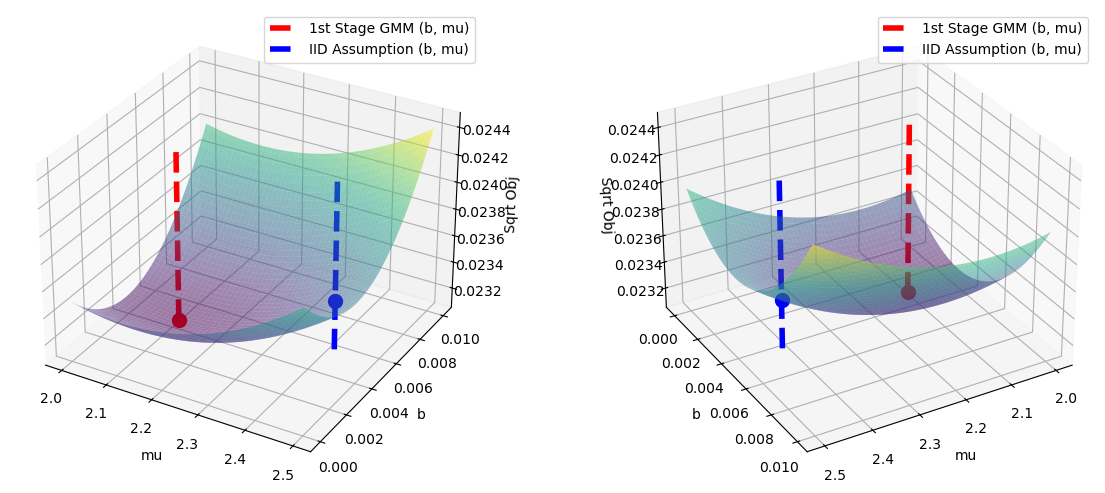

In [15]:

# Define the range for mu and b
b_range = np.linspace(2, 2.5, 100)
mu_range = np.linspace(0, 0.01, 100)

# Create a meshgrid for mu and b
b_grid, mu_grid = np.meshgrid(b_range, mu_range)

# Calculate the GMM objective function for each pair of (mu, b)
z_values = np.array(
    [
        gmm_objective_and_gradient((b, mu), X, W)[0] ** 0.5
        for b, mu in zip(np.ravel(b_grid), np.ravel(mu_grid))
    ]
)
z_grid = z_values.reshape(mu_grid.shape)

fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(121, projection="3d")
ax1.plot_surface(b_grid, mu_grid, z_grid, cmap="viridis", alpha=0.5)
ax1.plot([theta_hat_gmm[0]],[theta_hat_gmm[1]],[z_grid.min(), z_grid.max()], color="r", linestyle="--", linewidth=4, label="1st Stage GMM (b, mu)")
ax1.scatter(theta_hat_gmm[0], theta_hat_gmm[1], result.fun**0.5, color="r", s=100)
ax1.plot([theta_hat_iid[0]],[theta_hat_iid[1]],[z_grid.min(), z_grid.max()],color="b",linestyle="--",linewidth=4,label="IID Assumption (b, mu)")
ax1.scatter(theta_hat_iid[0],theta_hat_iid[1],gmm_objective_and_gradient(theta_hat_iid, X, W)[0] ** 0.5,color="b",s=100)
ax1.set_xlabel("mu")
ax1.set_ylabel("b")
ax1.set_zlabel("Sqrt Obj")
ax1.legend()

ax2 = fig.add_subplot(122, projection="3d")
ax2.plot_surface(b_grid, mu_grid, z_grid, cmap="viridis", alpha=0.5)
ax2.plot([theta_hat_gmm[0]],[theta_hat_gmm[1]],[z_grid.min(), z_grid.max()],color="r",linestyle="--",linewidth=4,label="1st Stage GMM (b, mu)")
ax2.scatter(theta_hat_gmm[0], theta_hat_gmm[1], result.fun**0.5, color="r", s=100)
ax2.plot([theta_hat_iid[0]],[theta_hat_iid[1]],[z_grid.min(), z_grid.max()],color="b",linestyle="--",linewidth=4,label="IID Assumption (b, mu)")
ax2.scatter(theta_hat_iid[0],theta_hat_iid[1],gmm_objective_and_gradient(theta_hat_iid, X, W)[0] ** 0.5,color="b",s=100)
ax2.view_init(elev=30, azim=60)  # Change the view angle
ax2.set_xlabel("mu")
ax2.set_ylabel("b")
ax2.set_zlabel("Sqrt Obj")
ax2.legend()

plt.subplots_adjust(wspace=0.3)
plt.show()